In [4]:
import pickle
import MySQLdb
import math
import numpy as np
from sklearn.metrics import mean_squared_error as MeanSE
from sklearn.metrics import mean_absolute_error as MeanAE
from sklearn.metrics import median_absolute_error as MedianAE
from sklearn.metrics import r2_score, explained_variance_score
import matplotlib.pyplot as plt
print ("Packages successfully loaded.")

Packages successfully loaded.


In [9]:
local_path = 'D:\\waiting time\\我的代码\\preprocessing_data\\'
with open(local_path+'raw_patients.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    raw_patients = u.load()

In [11]:
print(len(raw_patients))
#raw_patients.keys()
raw_patients[1054]

9699


{'2015-03-24': {'diagnosis': ['Resp'],
  'oncologist': ['1338'],
  'course': ['39079'],
  'appt_day_of_week': [3],
  'appt_hour': [13],
  'appt_month': [3],
  'plan': ['99865'],
  'orientation': ['HFS'],
  'avg_duration': 0.0,
  'appt_allocated': [15],
  'appt_duration': [19]},
 '2015-03-25': {'diagnosis': ['Resp'],
  'oncologist': ['1338'],
  'course': ['39079'],
  'appt_day_of_week': [4],
  'appt_hour': [13],
  'appt_month': [3],
  'plan': ['99865'],
  'orientation': ['HFS'],
  'avg_duration': 19.0,
  'appt_allocated': [15],
  'appt_duration': [12]},
 '2015-03-26': {'diagnosis': ['Resp'],
  'oncologist': ['1338'],
  'course': ['39079'],
  'appt_day_of_week': [5],
  'appt_hour': [13],
  'appt_month': [3],
  'plan': ['99865'],
  'orientation': ['HFS'],
  'avg_duration': 15.5,
  'appt_allocated': [15],
  'appt_duration': [17]},
 '2015-03-27': {'diagnosis': ['Resp'],
  'oncologist': ['1338'],
  'course': ['39079'],
  'appt_day_of_week': [6],
  'appt_hour': [10],
  'appt_month': [3],
  'p

In [12]:
# 得到每一个患者的date和duration，每一个患者是一个列表
def getPatientDateAndDuration(raw_patients):
    all_appt_duration = []
    all_appt_date = []
    for pat_num, appt_date in raw_patients.items():
        patient_appt_duration = []
        patient_appt_date = []
        for k in sorted(appt_date):
            every_appt = appt_date[k]
            if len(every_appt['appt_duration']) > 1:
                sum_appt = sum(every_appt['appt_duration'])
                if sum_appt != 0:
                    patient_appt_duration.append(sum_appt)
                    patient_appt_date.append(k)
            else:
                if every_appt['appt_duration'][0] != 0:
                    patient_appt_duration.append(every_appt['appt_duration'][0])
                    patient_appt_date.append(k)
        all_appt_duration.append(patient_appt_duration)
        all_appt_date.append(patient_appt_date)
    return all_appt_date, all_appt_duration


In [25]:
# 画出每一个患者duration的图像
def plotPatientDuration(patient_appt_duration, patient_appt_date, path):
    x = range(len(patient_appt_date))
    plt.figure(figsize=(10, 10)) 
    plt.bar(x, patient_appt_duration)
    plt.xticks(x, patient_appt_date)
    plt.xticks(rotation = 90)
    #plt.savefig('%s.png'%path)
    plt.show()

In [26]:
# 计算误差
def calculateErr(all_real, all_pred):
    median_value = MedianAE(all_pred, all_real)
    MAE = MeanAE(all_pred, all_real)
    MSE = MeanSE(all_pred, all_real)
    return median_value, MAE, MSE, math.sqrt(MSE)


In [27]:
# 不进行任何处理，直接用前一天的duration当作今天的预测duration
def getNoProcessResult(all_appt_duration):
    all_real = []
    all_pred = []
    for line in all_appt_duration:
        for i in line[1:]:
            all_real.append(i)
        for j in line[:-1]:
            all_pred.append(j)
            
    median_value, MAE, MSE, sqrtMSE = calculateErr(all_real, all_pred)
    
    print('median_value: ', median_value)
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    print('sqrt: ', sqrtMSE)
    
    return all_real, all_pred

In [37]:
import datetime


# 比较两次相邻的duration所间隔的天数
def compareDate(date1, date2, ndays = 7):
    date1 = datetime.datetime.strptime(date1, '%Y-%m-%d')
    date2 = datetime.datetime.strptime(date2, '%Y-%m-%d')
    interval = (date2 - date1).days
    if interval >= ndays:
        return True
    else:
        return False

In [38]:
# 根据duration时间段的不同，将每个患者的duration数据进行分割
def getDiffDateDuration(patient_appt_date, patient_appt_duration):
    new_patient_appt_date = []
    new_patient_appt_duration = []
    sign = [0]
    for i in range(len(patient_appt_date) - 1):
        date1 = patient_appt_date[i]
        date2 = patient_appt_date[i + 1]
        if compareDate(date1, date2):
            sign.append(i + 1)
    if sign == [0]:
        new_patient_appt_date.append(patient_appt_date)
        new_patient_appt_duration.append(patient_appt_duration)
    else:
        for i in range(len(sign) - 1):
            new_patient_appt_date.append(patient_appt_date[sign[i] : sign[i + 1]])
            new_patient_appt_duration.append(patient_appt_duration[sign[i] : sign[i + 1]])
    return new_patient_appt_date, new_patient_appt_duration


In [39]:
# 移动平均
def getMovingAve(patient_duration):
    patient_duration = patient_duration[:-1]
    pre_patient_duration = []
    if len(patient_duration) > 1:
        pre_patient_duration = [patient_duration[0]]
        for i in range(1, len(patient_duration)):
            pre_patient_duration.append(sum(patient_duration[:i+1]) / (i+1))
    elif len(patient_duration) == 1:
        pre_patient_duration.append(patient_duration[0])
    else:
        pre_patient_duration = []
    return pre_patient_duration

In [40]:
# 将间隔相差很远的duration数据分开
def getSepDuration(all_appt_date, all_appt_duration):
    new_all_appt_date = []
    new_all_appt_duration = []
    for i in range(len(all_appt_duration)):
        new_patient_appt_date, new_patient_appt_duration = getDiffDateDuration(all_appt_date[i], all_appt_duration[i])
        new_all_appt_date.append(new_patient_appt_date)
        new_all_appt_duration.append(new_patient_appt_duration)

    all_real = []
    all_pred = []
    for pat in new_all_appt_duration:
        for duration in pat:
            if len(duration) not in [0, 1, 2]:
                duration = duration[1:]
                for i in duration[1:]:
                    all_real.append(i)
                for n in duration[:-1]:
                    all_pred.append(n)  
    
    median_value, MAE, MSE, sqrtMSE = calculateErr(all_real, all_pred)
    print('median_value: ', median_value)
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    print('sqrt: ', sqrtMSE)

    return all_real, all_pred, new_all_appt_date, new_all_appt_duration

In [41]:
# 使用移动平均来预测
def getAvePredDuration(new_all_appt_duration):
    ave_all_real = []
    ave_all_pred = []
    for pat in new_all_appt_duration:
        for duration in pat:
            for i in getMovingAve(duration):
                ave_all_pred.append(i)     
                
    for pat in new_all_appt_duration:
        for duration in pat:
            if len(duration) > 2:
                for i in duration[1:]:
                    ave_all_real.append(i)
            elif len(duration) == 2:
                ave_all_real.append(duration[-1])
            else:
                continue
    median_value, MAE, MSE, sqrtMSE = calculateErr(ave_all_real, ave_all_pred)
    print('median_value: ', median_value)
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    print('sqrt: ', sqrtMSE)  
    
    return ave_all_real, ave_all_pred

In [42]:
def getAllocatedAsPred(raw_patients):
    all_appt_allocated = []
    all_appt_date = []
    for pat_num, appt_date in raw_patients.items():
        patient_appt_allocated = []
        patient_appt_date = []
        for k in sorted(appt_date):
            every_appt = appt_date[k]
            patient_appt_allocated.append(every_appt['appt_allocated'][0])
            patient_appt_date.append(k)
        all_appt_allocated.append(patient_appt_allocated)
        all_appt_date.append(patient_appt_date)
    return all_appt_date, all_appt_allocated

In [43]:
def compareAllocatedAndDuration(all_appt_duration, all_appt_allocated):
    all_real = []
    all_pred = []
    for pat in range(len(all_appt_duration)):
        for duration in range(len(all_appt_duration[pat])):
            if all_appt_duration[pat][duration] != 0:
                all_real.append(all_appt_duration[pat][duration])
                all_pred.append(all_appt_allocated[pat][duration])

    median_value, MAE, MSE, sqrtMSE = calculateErr(all_real, all_pred)
    
    print('median_value: ', median_value)
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    print('sqrt: ', sqrtMSE)
    
    return all_real, all_pred

In [44]:
# 画出数据分布图，真实值和预测值的差值
def plotErrDistribution(all_real, all_pred, name, path = 'PatientDuration//'):
    error = [all_real[i] - all_pred[i] for i in range(len(all_real))]
    plt.figure(figsize=(10, 10)) 
    plt.hist(error, range(-39, 18, 3))
    plt.xticks(range(-39, 18, 3))
    plt.grid()
    plt.xlabel('Prediction-Actual [min]')
    plt.ylabel('Number of Testing Samples')
    plt.title(name)
    #plt.savefig('%s.png'%(path+name))
    plt.show()

9699
9699


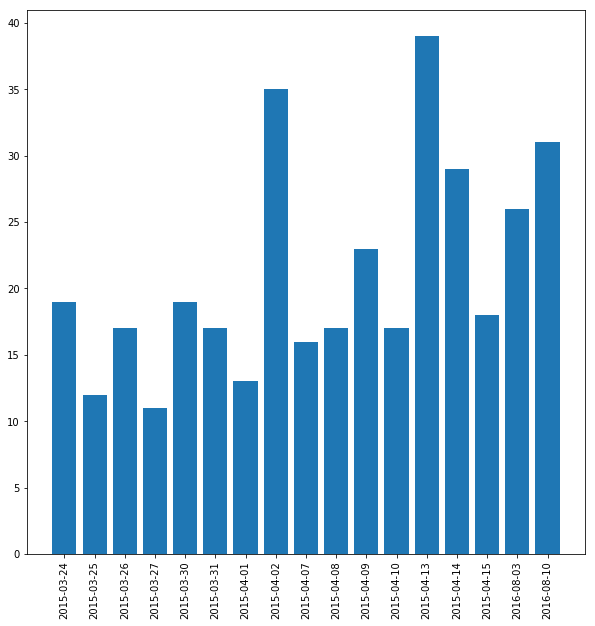

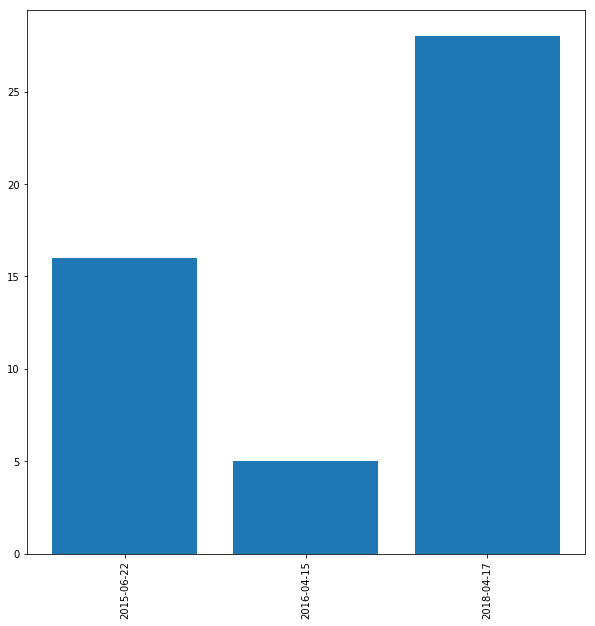

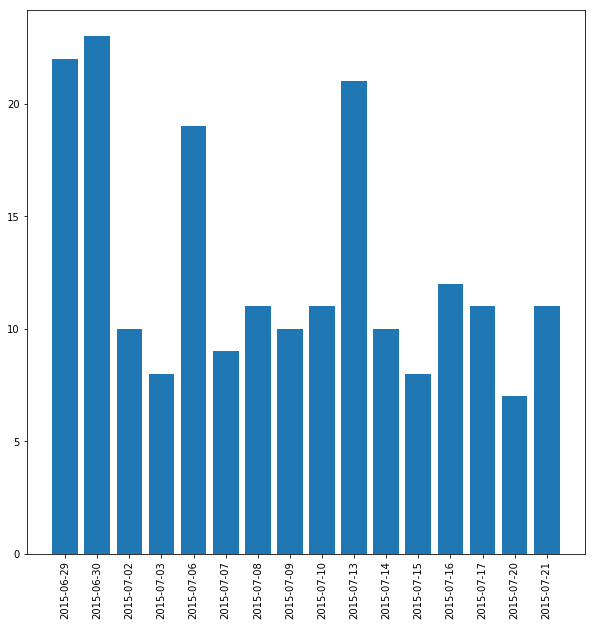

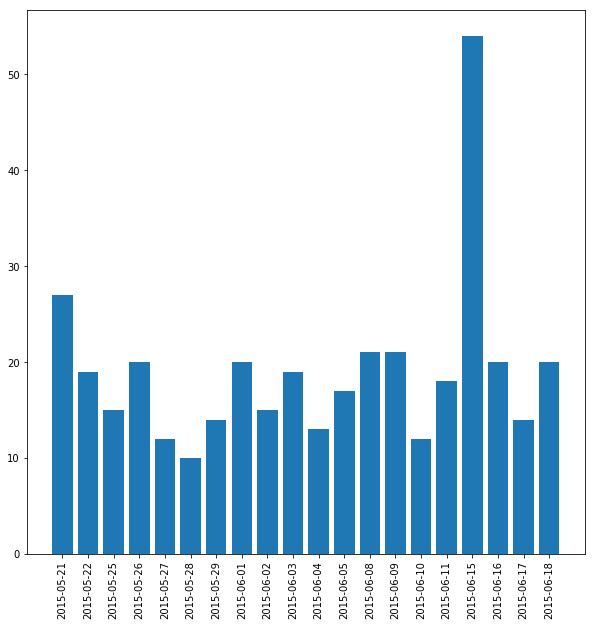

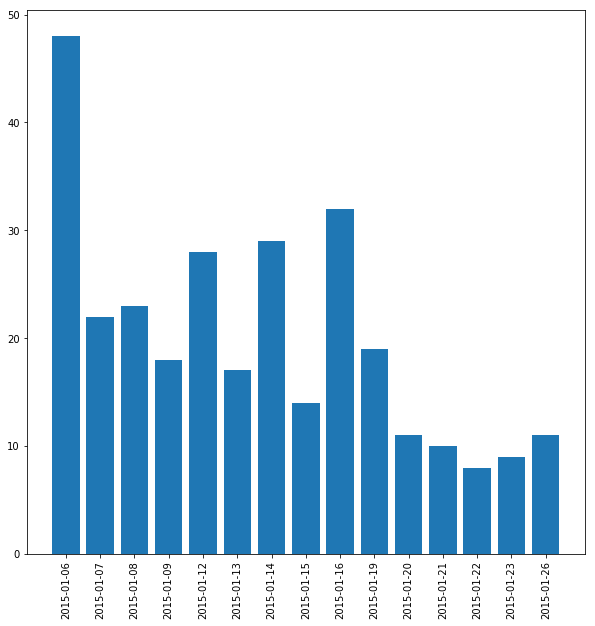

Contain first day: 
median_value:  4.0
MAE:  6.581169371304124
MSE:  105.97972656190923
sqrt:  10.294645528715849


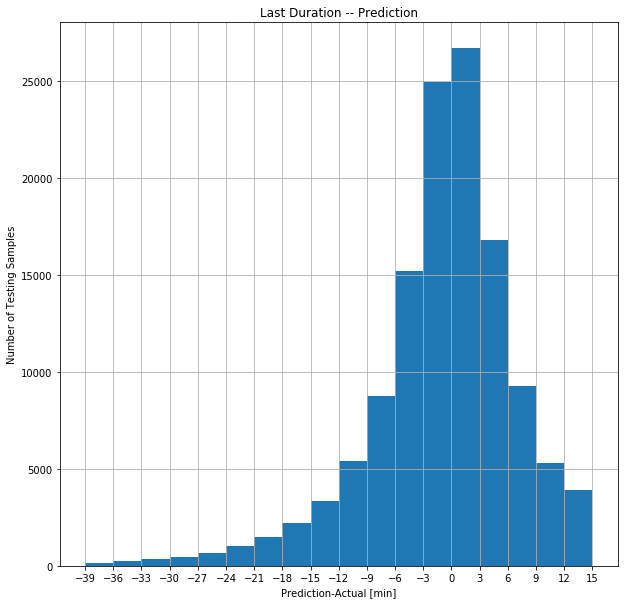



Doesn't contain first day: 
median_value:  4.0
MAE:  6.174665998933781
MSE:  92.86501025831569
sqrt:  9.636649327350025


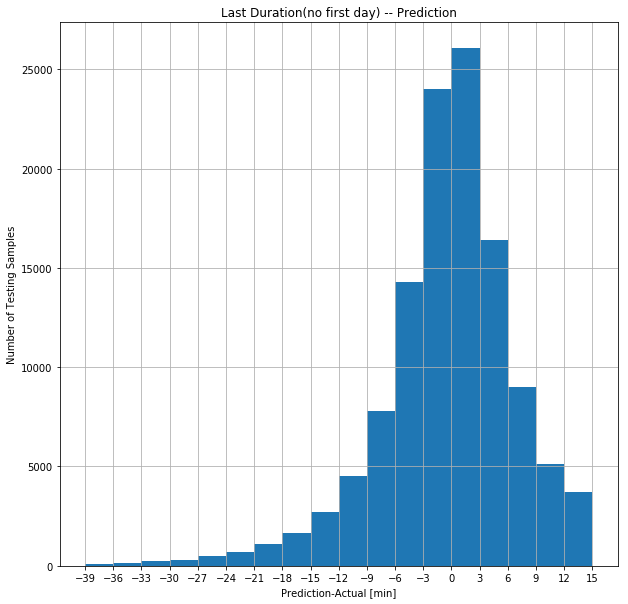



Doesn't contain first day
Separate big interval of durations: 
median_value:  4.0
MAE:  5.958597873314503
MSE:  84.15768742387728
sqrt:  9.17374991068959


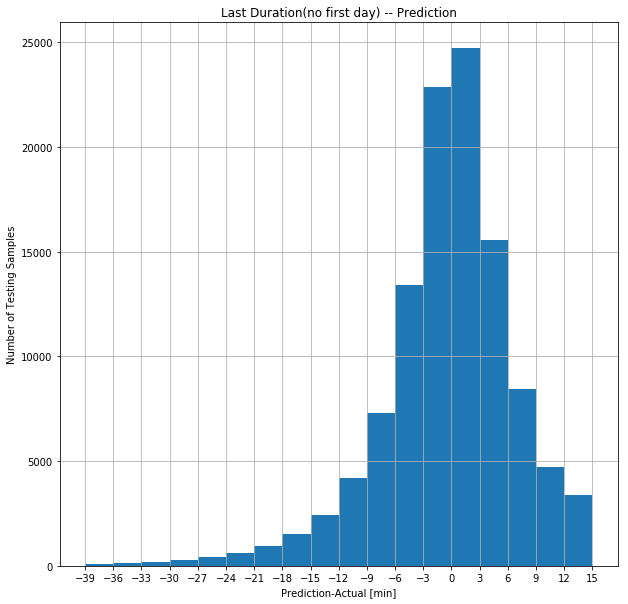



Doesn't contain first day
Separate big interval of durations
Use Moving Average: 
median_value:  4.192307692307692
MAE:  5.8811549130955765
MSE:  76.18378714960484
sqrt:  8.728332438078011


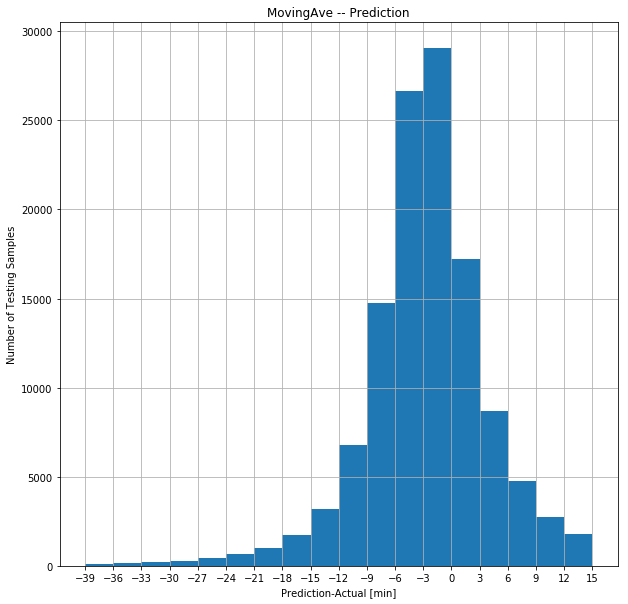



Use Allocated appointment time as Prediction: 
median_value:  4.0
MAE:  6.5171921996130875
MSE:  104.23011423810667
sqrt:  10.209315071938306


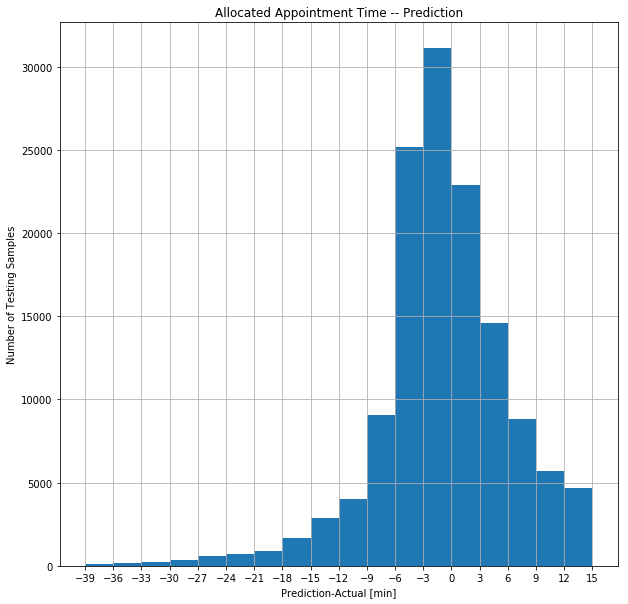

In [46]:
# 画图
all_appt_date, all_appt_duration = getPatientDateAndDuration(raw_patients)
print(len(all_appt_date))
print(len(all_appt_duration))

for i in range(len(all_appt_duration[30:35])):
    plotPatientDuration(all_appt_duration[i], all_appt_date[i], 'PatientDuration//PatientSequence//patient%d'%(i+1))


# 去掉第一天的预测，平均偏差会减小
print('Contain first day: ')
all_real, all_pred = getNoProcessResult(all_appt_duration)
plotErrDistribution(all_real, all_pred, 'Last Duration -- Prediction')

print('\n\nDoesn\'t contain first day: ')
all_appt_duration_del = [i[1:] for i in all_appt_duration]
all_real1, all_pred1 = getNoProcessResult(all_appt_duration_del)
plotErrDistribution(all_real1, all_pred1, 'Last Duration(no first day) -- Prediction')

print('\n\nDoesn\'t contain first day\nSeparate big interval of durations: ')
all_real, all_pred, new_all_appt_date, new_all_appt_duration = getSepDuration(all_appt_date, all_appt_duration)
plotErrDistribution(all_real, all_pred, 'Last Duration(no first day) -- Prediction')

print('\n\nDoesn\'t contain first day\nSeparate big interval of durations\nUse Moving Average: ')
ave_all_real, ave_all_pred = getAvePredDuration(new_all_appt_duration)
plotErrDistribution(ave_all_real, ave_all_pred, 'MovingAve -- Prediction')

print('\n\nUse Allocated appointment time as Prediction: ')
all_appt_date, all_appt_allocated = getAllocatedAsPred(raw_patients)
all_real_allocated, all_pred_allocated = compareAllocatedAndDuration(all_appt_duration, all_appt_allocated)
plotErrDistribution(all_real_allocated, all_pred_allocated, 'Allocated Appointment Time -- Prediction')

